In [14]:
# RNN for iEEG data
# data from  http://ieeg-swez.ethz.ch/
# Segessenmann J. 2020

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

In [38]:
# parameters
ch_start = 0  # first channel of used channels
ch_end = 20  # last channel of used channels
nr_samples = 2000  # the first nr_samples are used
window_size = 50
normalization = True

channel_size = ch_end - ch_start
channel_pos = list(range(ch_start, ch_end))

data_mat = loadmat('./data/ID02_1h.mat')
data_raw = data_mat['EEG'][ch_start:ch_end, :nr_samples].transpose()

if normalization:
    sc = MinMaxScaler(feature_range=(-1, 1))
    sc.fit(data_raw)
    data = sc.transform(data_raw)

# to tensor
data = torch.FloatTensor(data)

# split data
train_portion = 0.8
train_set = data[:int(train_portion * nr_samples), :]
test_set = data[int(train_portion * nr_samples):, :]

# prepare data for learning
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, :])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, :])

In [39]:
class FFNN(nn.Module):
    def __init__(self, channel_pos_all: list, hidden_size=10, recurrence=0.5):
        super().__init__()
        # Parameters
        self.hidden_size = hidden_size
        self.visible_size = len(channel_pos_all)
        self.full_size = self.visible_size + self.hidden_size
        self.channel_pos_all = channel_pos_all.copy()
        # Create FC Layer
        self.W = nn.Linear(self.full_size, self.hidden_size)
        self.U = nn.Linear(self.full_size, self.visible_size)
        # Initialize gate s
        self.s = torch.ones(self.visible_size, dtype=torch.float32)
        self.recurrence = recurrence
        
    def make_gate(self, channel_pos_out: list, new_recurrence=None):
        # Define input channels
        channel_pos_in = self.channel_pos_all.copy()
        for _, val in enumerate(channel_pos_out):
            channel_pos_in.remove(val)
        # Optionale new recurrence factor
        if new_recurrence is not None:
            self.recurrence = new_recurrence
        # Define gate s
        self.s[channel_pos_in] = self.recurrence

    def forward(self, X):
        # Initialize all nodes
        r = torch.zeros(self.full_size, dtype=torch.float32)
        # Forward path
        for i in range(X.shape[0]):
            hidden = self.W(r)
            visible = torch.mul(self.s, self.U(r)) + torch.mul((1-self.s), X[i,:])
            u = torch.cat((visible, hidden), 0)
            r = torch.tanh(u)
        return r[:self.visible_size]

In [35]:
channel_pos

[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19]

Epoch: 0 Loss: 0.036844113237870436
Epoch: 1 Loss: 0.028101327274259433
Epoch: 2 Loss: 0.024138266071060708
Epoch: 3 Loss: 0.02174689913927919
Epoch: 4 Loss: 0.020111941469629527
1.3381062269210815


(Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss'))

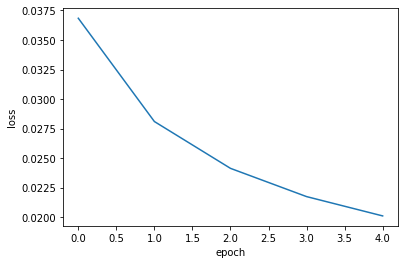

In [42]:
model = FFNN(channel_pos)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5

start_time = time.time()
temp_loss = []
epoch_loss = []

ch_out = [2, 10, 12]
model.make_gate(ch_out, new_rec=0.5)

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred[ch_out], X[-1, ch_out])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')

total_time = time.time() - start_time
print(total_time / 60)

plt.figure()
plt.plot(np.asarray(epoch_loss))
plt.xlabel('epoch'), plt.ylabel('loss')

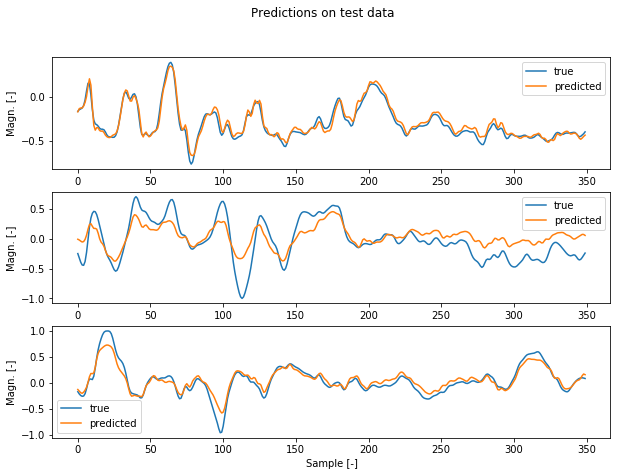

In [48]:
model.eval()

Y_preds = []
Y = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_all = model(X).numpy()
        Y_preds.append(Y_all[ch_out]) 
        Y.append(X[-1, ch_out].numpy())
        
preds = np.asarray(Y_preds)
Y_test_np = np.asarray(Y)

fig, ax = plt.subplots(3, figsize=(10, 7))
fig.suptitle('Predictions on test data')
ax[0].plot(Y_test_np[:,0], label='true')
ax[0].plot(preds[:,0], label='predicted')
ax[0].set_ylabel('Magn. [-]')
ax[0].legend()
ax[1].plot(Y_test_np[:,1], label='true')
ax[1].plot(preds[:,1], label='predicted')
ax[1].set_ylabel('Magn. [-]')
ax[1].legend()
ax[2].plot(Y_test_np[:,2], label='true')
ax[2].plot(preds[:,2], label='predicted')
ax[2].set_ylabel('Magn. [-]'), ax[2].set_xlabel('Sample [-]')
ax[2].legend()
fig.savefig('fig_0428_predictions_frec_50.png')

In [33]:
model.U.weight.data

tensor([[-1.8771e-01, -1.4600e-01, -4.5254e-01, -2.3832e-01, -6.9439e-02,
          5.0185e-03, -3.8147e-01, -4.4514e-01, -4.7184e-01, -1.0327e+00,
          1.6379e-02, -1.5070e-01,  4.7658e-01,  2.7602e-03,  3.3413e-01,
         -2.5641e-01,  1.0689e-01, -1.3294e-02,  1.1661e-01,  9.1332e-04,
         -1.3440e-02,  3.3187e-01,  3.2454e-01, -1.0012e-01, -1.6123e-01,
          8.9234e-02,  1.9717e-01, -1.1956e-01,  1.9320e-01,  2.8183e-01],
        [-5.6481e-01, -2.6755e-01, -8.1336e-01, -3.4740e-01, -4.6249e-01,
         -1.8695e-01, -5.7213e-01, -6.7656e-01, -2.6830e-01,  1.7902e-01,
         -3.4908e-01,  8.3201e-04,  3.1264e-01,  1.1268e-01,  2.4333e-01,
          7.9109e-02,  6.7393e-03,  4.6433e-02, -6.2151e-02,  2.0881e-01,
          3.5773e-01, -2.2383e-01,  1.6486e-01,  3.3077e-02,  3.7415e-01,
          3.3630e-01, -1.0474e-02,  2.9243e-01,  7.9495e-02, -1.5793e-02],
        [ 2.9217e-01,  4.5205e-01,  5.7684e-02,  6.2066e-01,  4.1996e-01,
          4.4052e-02,  1.1397e-02,  